In [ ]:
conda install -c conda-forge cartopy

In [ ]:
conda install -c conda-forge folium

In [ ]:
conda install -c conda-forge geopandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
import datetime
import shapely as sp
from shapely.geometry import Point, Polygon, box
import io
np.random.seed(0)
import os

In [2]:
Earthquake = pd.read_csv('EQ.csv')

In [3]:
missing_values_columns = [col for col in Earthquake.columns
                          if Earthquake[col].isnull().any()]
Earthquakes = Earthquake.drop(missing_values_columns, axis=1)
Earthquakes.head()

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,6.0,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,5.8,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,5.8,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [4]:
EQ = pd.DataFrame(Earthquake,columns=['Date', 'Time', 'Latitude', 'Longitude', 'Magnitude'])
EQ

,Date,Time,Latitude,Longitude,Magnitude
0,01/02/1965,13:44:18,19.2460,145.6160,6.0
1,01/04/1965,11:29:49,1.8630,127.3520,5.8
2,01/05/1965,18:05:58,-20.5790,-173.9720,6.2
3,01/08/1965,18:49:43,-59.0760,-23.5570,5.8
4,01/09/1965,13:32:50,11.9380,126.4270,5.8
...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,5.6
23408,12/28/2016,09:13:47,38.3777,-118.8957,5.5
23409,12/28/2016,12:38:51,36.9179,140.4262,5.9
23410,12/29/2016,22:30:19,-9.0283,118.6639,6.3


In [5]:
TectonicPlates = pd.read_csv('TP.csv')

In [6]:
missing_values_columns = [col for col in TectonicPlates.columns
                          if TectonicPlates[col].isnull().any()]
TectonicPlates = TectonicPlates.drop(missing_values_columns, axis=1)
TectonicPlates.head()

,plate,lat,lon
0,am,30.754,132.824
1,am,30.970,132.965
2,am,31.216,133.197
3,am,31.515,133.500
4,am,31.882,134.042


Text(0, 0.5, 'Longitude')

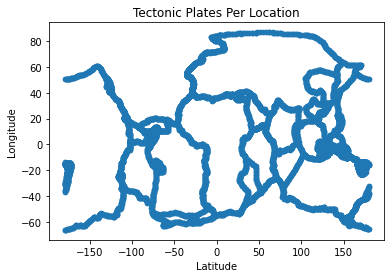

In [7]:
Plot = TectonicPlates.plot.scatter(x='lon', y='lat')
Plot.set_title("Tectonic Plates Per Location")
Plot.set_xlabel("Latitude")
Plot.set_ylabel("Longitude")

Text(0, 0.5, 'Latitude')

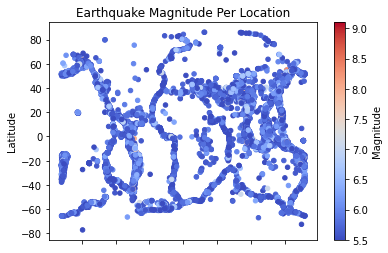

In [8]:
Plot = EQ.plot.scatter(x='Longitude', y='Latitude', c='Magnitude', cmap='coolwarm')
Plot.set_title("Earthquake Magnitude Per Location")
Plot.set_xlabel("Longitude")
Plot.set_ylabel("Latitude")

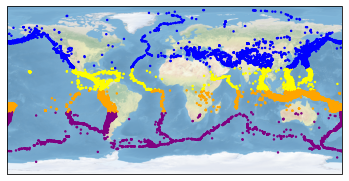

In [9]:
# Generate data points on a stock image map to see the number of earthquakes by zone.
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.feature as cfeature
import seaborn as sns

earthquakes = pd.read_csv('earthquakes.csv')

ax = plt.axes(projection=ccrs.PlateCarree()) #also try LambertConformal PlateCarree
ax.stock_img()

# Color by Latitude Zone
colors = {'Northern' : 'blue', 'Tropic of Cancer' : 'yellow' , 'Equator': 'red', 'Tropic of Capricorn' : 'orange', 'Southern' : 'purple'}

ax.scatter(
   earthquakes['Longitude'],
   earthquakes['Latitude'],
   s = 2,
   c=earthquakes['TropicZone'].map(colors)
   )


plt.show()

In [10]:
# To show number of earthquakes in each zone shown above
print (earthquakes.groupby(['TropicZone']).size())

TropicZone
Equator                   1
Northern               6248
Southern               4121
Tropic of Cancer       4369
Tropic of Capricorn    8673
dtype: int64


In [11]:
TectonicPlates.head()

,plate,lat,lon
0,am,30.754,132.824
1,am,30.970,132.965
2,am,31.216,133.197
3,am,31.515,133.500
4,am,31.882,134.042


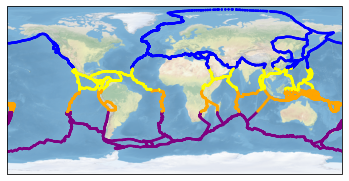

In [12]:
# Map of Plate Boundaries
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

# Color by Latitude Zone
colors = np.where(TectonicPlates['lat'] < -23.5, 'purple',
         np.where((TectonicPlates['lat'] >= -23.5) & (TectonicPlates['lat'] <= 0), 'orange', 
         np.where((TectonicPlates['lat'] > 0) & (TectonicPlates['lat']<=23.5), 'yellow', 
         np.where(TectonicPlates['lat'] > 23.5, 'blue', 'black'))))

plt.scatter(
   TectonicPlates['lon'],
   TectonicPlates['lat'],
   s = 2,
   c=colors
   )


plt.show()

In [13]:
TectonicPlates['lon2'] = TectonicPlates['lon'].shift(-1)
TectonicPlates['lat2'] = TectonicPlates['lat'].shift(-1)


from numpy import cos, sin, arcsin, sqrt
from math import radians

def haversine(row):
    lon1 = row['lon']
    lat1 = row['lat']
    lon2 = row['lon2']
    lat2 = row['lat2']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    km = 6367 * c
    return km

TectonicPlates['distance'] = TectonicPlates.apply(haversine, axis=1)
TectonicPlates

,plate,lat,lon,lon2,lat2,distance
0,am,30.754,132.824,132.965,30.970,27.514513
1,am,30.970,132.965,133.197,31.216,35.138223
2,am,31.216,133.197,133.500,31.515,43.938305
3,am,31.515,133.500,134.042,31.882,65.492548
4,am,31.882,134.042,134.691,32.200,70.612301
...,...,...,...,...,...,...
12316,yz,19.713,113.274,113.517,19.288,53.650956
12317,yz,19.288,113.517,113.759,18.863,53.632531
12318,yz,18.863,113.759,114.000,18.438,53.613210
12319,yz,18.438,114.000,114.000,18.438,0.000000


In [14]:
PlateBoundaryDistNorthern = TectonicPlates.loc[TectonicPlates['lat'] > 23.5, 'distance'].sum()
PlateBoundaryDistTropicCancer = TectonicPlates.loc[(TectonicPlates['lat'] > 0) & (TectonicPlates['lat'] <=23.5), 'distance'].sum()
PlateBoundaryDistTropicCapricorn = TectonicPlates.loc[(TectonicPlates['lat'] <= 0) & (TectonicPlates['lat'] >= -23.5), 'distance'].sum()
PlateBoundaryDistTropicSouthern = TectonicPlates.loc[TectonicPlates['lat'] > -23.5, 'distance'].sum()

In [15]:
print(PlateBoundaryDistNorthern)

218487.70229451937


In [16]:
print(PlateBoundaryDistTropicCancer)

298232.4237275835


In [17]:
print(PlateBoundaryDistTropicCapricorn)

268194.1591630462


In [18]:
print(PlateBoundaryDistTropicSouthern)

784914.2851851492


In [19]:
TectonicPlates

,plate,lat,lon,lon2,lat2,distance
0,am,30.754,132.824,132.965,30.970,27.514513
1,am,30.970,132.965,133.197,31.216,35.138223
2,am,31.216,133.197,133.500,31.515,43.938305
3,am,31.515,133.500,134.042,31.882,65.492548
4,am,31.882,134.042,134.691,32.200,70.612301
...,...,...,...,...,...,...
12316,yz,19.713,113.274,113.517,19.288,53.650956
12317,yz,19.288,113.517,113.759,18.863,53.632531
12318,yz,18.863,113.759,114.000,18.438,53.613210
12319,yz,18.438,114.000,114.000,18.438,0.000000


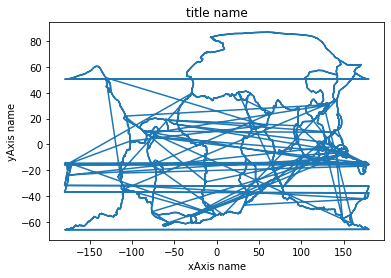

In [20]:
plt.plot(TectonicPlates['lon'],TectonicPlates['lat'])
plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

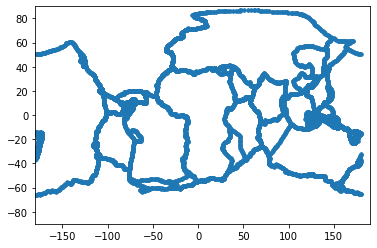

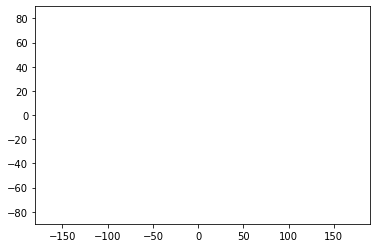

In [21]:
import numpy as np
import matplotlib.pyplot as py
from matplotlib import animation

#py.close('all') # close all previous plots

# create a random line to plot
#------------------------------------------------------------------------------

x = TectonicPlates['lon']
y = TectonicPlates['lat']

py.figure(1)
py.scatter(x, y, s=10)
py.axis([-180, 190, -90, 90])
py.show()

# animation of a scatter plot using x, y from above
#------------------------------------------------------------------------------

fig = py.figure(2)
ax = py.axes(xlim=(-180, 190), ylim=(-90, 90))
scat = ax.scatter([], [], s=10)

def init():
    scat.set_offsets([])
    return scat,

def animate(i):
    data = np.hstack((x[:i,np.newaxis], y[:i, np.newaxis]))
    scat.set_offsets(data)
    return scat,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(x)+1, 
                               interval=200, blit=False, repeat=True)

In [22]:
TectonicPlates.plate.unique()

array(['am', 'an', 'AP', 'ar', 'AS', 'AT', 'au', 'BH', 'BR', 'BS', 'BU',
       'ca', 'CL', 'co', 'cp', 'CR', 'EA', 'eu', 'FT', 'GP', 'in', 'jf',
       'JZ', 'KE', 'lw', 'MA', 'MN', 'MO', 'mq', 'MS', 'na', 'NB', 'ND',
       'NH', 'NI', 'nu', 'nz', 'OK', 'ON', 'pa', 'PM', 'ps', 'ri', 'sa',
       'SB', 'sc', 'SL', 'sm', 'sr', 'SS', 'su', 'sw', 'TI', 'TO', 'WL',
       'yz'], dtype=object)

In [23]:
import pandas as pd
import numpy as np

# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [24]:
TectonicPlates['dist'] = \
    np.concatenate(TectonicPlates.groupby('plate')
                     .apply(lambda x: haversine(x['lat'], x['lon'],
                                                x['lat'].shift(), x['lon'].shift())).values)

In [25]:
TectonicPlates.head()

,plate,lat,lon,lon2,lat2,distance,dist
0,am,30.754,132.824,132.965,30.970,27.514513,NaN
1,am,30.970,132.965,133.197,31.216,35.138223,93.859686
2,am,31.216,133.197,133.500,31.515,43.938305,91.123216
3,am,31.515,133.500,134.042,31.882,65.492548,93.061743
4,am,31.882,134.042,134.691,32.200,70.612301,71.532169


In [26]:
PBDistNorthern = TectonicPlates.loc[TectonicPlates['lat'] > 23.5, 'dist'].sum()
PBDistTropicCancer = TectonicPlates.loc[(TectonicPlates['lat'] > 0) & (TectonicPlates['lat'] <=23.5), 'dist'].sum()
PBDistTropicCapricorn = TectonicPlates.loc[(TectonicPlates['lat'] <= 0) & (TectonicPlates['lat'] >= -23.5), 'dist'].sum()
PBDistSouthern = TectonicPlates.loc[TectonicPlates['lat'] > -23.5, 'dist'].sum()

In [27]:
print(PBDistNorthern)

142939.81351586015


In [28]:
print(PBDistTropicCancer)

136248.83469451955


In [29]:
print(PBDistTropicCapricorn)

135547.81308224172


In [30]:
print(PBDistSouthern)

414736.46129262145


In [32]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

gdf = gpd.GeoDataFrame(earthquakes, geometry=gpd.points_from_xy(earthquakes.Longitude, earthquakes.Latitude))

In [33]:
print(gdf.head())

   Unnamed: 0        Date      Time  Latitude  Longitude        Type  Depth  \
0           1  1965-01-02  13:44:18    19.246    145.616  Earthquake  131.6   
1           2  1965-01-04  11:29:49     1.863    127.352  Earthquake   80.0   
2           3  1965-01-05  18:05:58   -20.579   -173.972  Earthquake   20.0   
3           4  1965-01-08  18:49:43   -59.076    -23.557  Earthquake   15.0   
4           5  1965-01-09  13:32:50    11.938    126.427  Earthquake   15.0   

   Magnitude            ID MonthDay Hemisphere    Season  LandSea  \
0        6.0  ISCGEM860706    01/02    Tropics  Tropical     True   
1        5.8  ISCGEM860737    01/04    Tropics  Tropical     True   
2        6.2  ISCGEM860762    01/05    Tropics  Tropical     True   
3        5.8  ISCGEM860856    01/08   Southern    Summer     True   
4        5.8  ISCGEM860890    01/09    Tropics  Tropical     True   

            TropicZone                      geometry  
0     Tropic of Cancer    POINT (145.61600 19.24600)  


In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

In [ ]:


# Convert it to a GeoDataFrame by transforming the Latitude/Longitude coordinates 
loc_crs = {'init': 'epsg:4326'}
loc_geom = [Point(xy) for xy in zip(earthquakes['Longitude'], earthquakes['Latitude'])]
geo_df = gpd.GeoDataFrame(earthquakes, geometry=loc_geom)

# Plot the GeoDataFrame
geo_df.plot()

In [ ]:
earthquakes.head()

In [3]:
BoundaryCoordinates7 = pd.read_csv("BoundaryCoordinates7.csv")

In [25]:
BoundaryCoordinates7

,Unnamed: 0,Point1,Point2,Point3,Point4,Point5,Point6,Point7,Point8,Point9,...,Point90,Point91,Point92,Point93,Point94,Point95,Point96,Point97,Point98,Distance
0,1,"86.6060028079833 , 66.3010025028633","86.6549987795701 , 66.5439987180665",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.700115
1,2,"86.6549987795701 , 66.5439987180665","86.7549972532207 , 62.463001250907","86.8050003054198 , 61.5060005190088","86.7870025636175 , 58.0180015560271","86.7460021972437 , 54.5610008237291","86.7060012816339 , 50.770000457655","86.6409988399246 , 47.522998810147","86.597999572922 , 46.0629997251572",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.700115
2,3,"86.597999572922 , 46.0629997251572","86.5609970096044 , 46.313999176321",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.700115
3,4,"86.4039611818631 , 70.0894851683059","86.6060028079833 , 66.3010025028633",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.700115
4,5,"86.5609970096044 , 46.313999176321","86.496002196844 , 43.4790000913812","86.431999206798 , 41.7560005189089","86.2910003658743 , 38.300998688139","86.1610031132032 , 35.6069984432236","86.053001403592 , 33.3400001521853","85.9079971315624 , 30.9720001218082","85.8099975585405 , 29.2290000919807","85.8740005494858 , 28.1429996489147",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.700115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,1171,"-9.17719466460204 , 156.099547897518","-9.19651658437283 , 156.097210213281","-9.27178943583374 , 155.832489555648","-9.31982966730527 , 155.160501182384",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.700115
1171,1172,"-9.00994718881168 , 156.119782522146","-9.17719466460204 , 156.099547897518",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.700115
1172,1173,"-8.94740835621064 , 156.447843707621","-9.00973936897662 , 156.119807665392","-9.00994718881168 , 156.119782522146",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.700115
1173,1174,"35.4269981383534 , 29.7310008999716","35.4249992368254 , 29.3449993133677","35.3779983518425 , 29.0699996952298","35.3120002742933 , 28.7789993284563","35.1269989015781 , 28.4780006409169","34.8699989318053 , 28.0499992371751","34.7060012821335 , 27.6840000153884","34.4660683089054 , 27.2022821436061","34.0099244068859 , 26.2315143533048",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.700115


In [24]:
BoundaryCoordinates7.replace("NA , NA", np.nan, inplace=True)

In [5]:
from geopy.distance import geodesic

In [34]:
BoundaryCoordinates7['Distance'] = sum(geodesic((BoundaryCoordinates7.iloc[0,1]),(BoundaryCoordinates7.iloc[0,2])).km

SyntaxError: unexpected EOF while parsing (1697011081.py, line 1)